## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
!pip install opencv-python
import os
from glob import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, average_precision_score
from random import sample 

import cv2
from workspace_utils import active_session

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()

df = all_xray_df.copy()
df.head()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label) > 1:
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

df['pneumonia_class'] = df['Pneumonia'].map({1.0: 'P', 0.0: 'N'})
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
92056,00022977_007.png,Effusion|Infiltration|Nodule,7,22977,43,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,N
44609,00011462_002.png,No Finding,2,11462,58,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
52585,00013261_004.png,No Finding,4,13261,67,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N


## Create your training and testing data:

In [5]:
def balance_split(df, proportion = 1):
    p_inds = df[df['pneumonia_class'] == 'P'].index.tolist()
    np_inds = df[df['pneumonia_class'] == 'N'].index.tolist()

    np_sample = sample(np_inds,proportion*len(p_inds))
    data = df.loc[p_inds + np_sample]
    
    return data

def create_splits(df, test_size=0.2):
    y = df['pneumonia_class']
    
    train_data, val_data = train_test_split(df, test_size=test_size, stratify=y)
    
    train_data = balance_split(train_data, 1)
    val_data = balance_split(val_data, 4)

    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
def my_image_augmentation():
    idg = ImageDataGenerator(
        rescale=1./255.0,
        horizontal_flip=True,
        vertical_flip=False,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1)
    
    return idg

IMAGE_SIZE = (224, 224)

def make_gen(df, idg, batch_size=32):
    gen = idg.flow_from_dataframe(
        dataframe=df,
        directory=None,
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=IMAGE_SIZE,
        batch_size=batch_size
    )
    
    return gen


In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_data, val_data = create_splits(df)
train_idg = my_image_augmentation()
val_idg = ImageDataGenerator(rescale=1./255.0)

train_gen = make_gen(train_data, train_idg, batch_size=32)
val_gen = make_gen(val_data, val_idg, batch_size=64)

valX, valY = val_gen.next()


Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [8]:
print('Training data distribution:\n', train_data['pneumonia_class'].value_counts(normalize=True))
print('Validation data distribution:\n', val_data['pneumonia_class'].value_counts(normalize=True))

Training data distribution:
 N    0.5
P    0.5
Name: pneumonia_class, dtype: float64
Validation data distribution:
 N    0.8
P    0.2
Name: pneumonia_class, dtype: float64


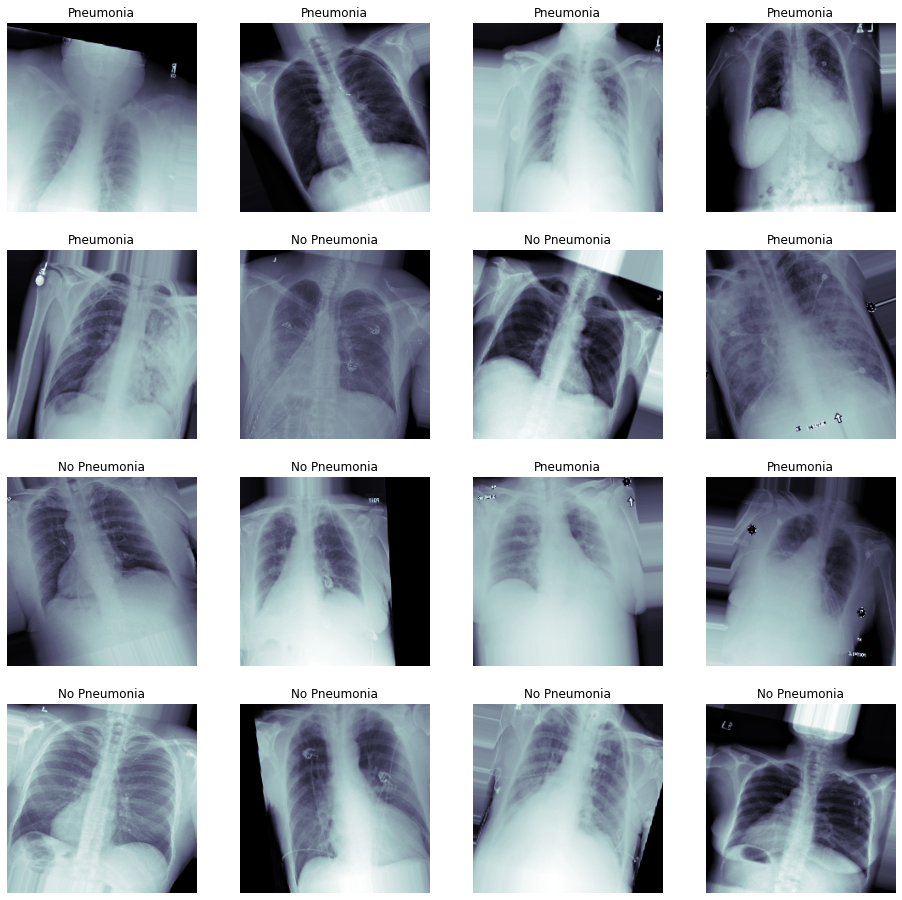

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
def load_pretrained_model(vargs):
    include_top = vargs.get('include_top', True)
    weights = vargs.get('weights', 'imagenet')
    layer_of_interest = vargs.get('layer_of_interest', 'block5_pool')
    model = VGG16(include_top=include_top, weights=weights)

    freeze_layers_upto = vargs.get('freeze_layers_upto', len(model.layers))

    for layer in model.layers[:freeze_layers_upto]:
        layer.trainable = False

    for layer in model.layers:
        print(layer.name, layer.trainable)
        
    model.summary()
 
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
        
    return vgg_model

In [11]:
def build_my_model(vargs):
    dropout_rate = vargs.get('dropout_rate', 0.5)

    pretrained_model = load_pretrained_model(vargs)

    my_model = Sequential()

    my_model.add(pretrained_model)

    my_model.add(Flatten())
    my_model.add(Dropout(dropout_rate))

    layers_units = [1024, 512, 256]

    for units in layers_units:
        my_model.add(Dense(units, activation='relu'))
        my_model.add(Dropout(dropout_rate))

    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=vargs.get('learning_rate', 1e-4))
    my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    my_model.summary()
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

monitor_metric = 'val_loss'
mode = 'min'

checkpoint = ModelCheckpoint(weight_path, 
                             monitor=monitor_metric, 
                             verbose=1, 
                             save_best_only=True, 
                             mode=mode, 
                             save_weights_only=True)

early = EarlyStopping(monitor=monitor_metric, 
                      mode=mode, 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [13]:
vargs = {
    'include_top': True,
    'weights': 'imagenet',
    'layer_of_interest': 'block5_pool',
    'freeze_layers_upto': 17,
    'learning_rate': 1e-4,
    'dropout_rate': 0.3
}


In [14]:
my_model = build_my_model(vargs)
if os.path.exists(weight_path):
    my_model.load_weights(weight_path)
else:
    print(f"No weights file found at {weight_path}, training from scratch.")

num_epochs = 30
history = my_model.fit_generator(train_gen,
                        validation_data=(valX, valY), 
                        epochs=num_epochs, 
                        callbacks=callbacks_list)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True
predictions True
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0    

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [15]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

my_model = build_my_model(vargs)

my_model.load_weights(weight_path)
pred_Y = my_model.predict(x=valX, batch_size=32, verbose=True)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
flatten True
fc1 True
fc2 True
predictions True
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0    

In [17]:
def plot_auc(t_y, p_y):
    fpr, tpr, _ = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return

def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
def plot_history(h):
    N = len(h["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), h["loss"], label="train_loss")
    plt.plot(np.arange(0, N), h["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), h["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), h["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

Precision is: 0.625
Recall is: 0.5555555555555556
Threshold is: 0.5456092
F1 Score is: 0.5882352941176471


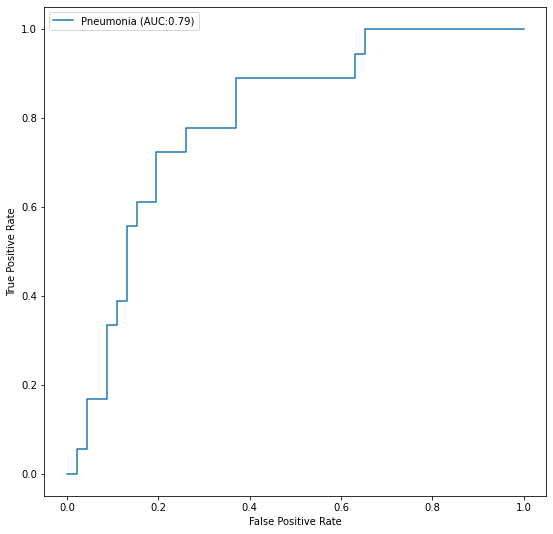

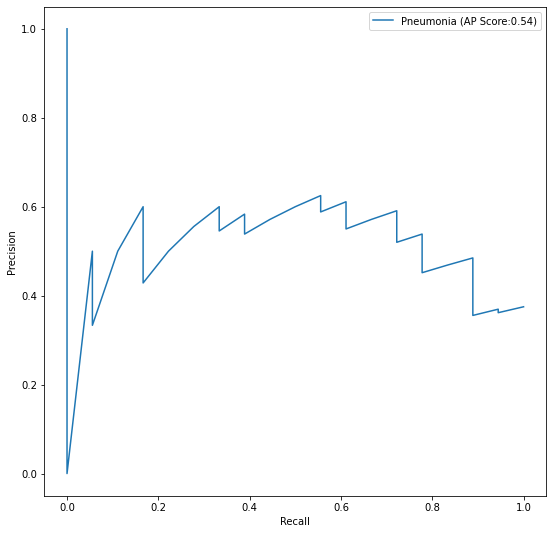

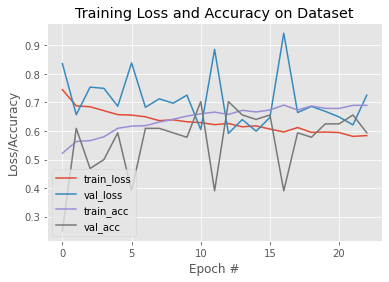

In [18]:
## plot figures
ground_truth_binary = valY
plot_roc_curve(ground_truth_binary,pred_Y)

plot_precision_recall_curve(ground_truth_binary, pred_Y)

precision, recall, thresholds = precision_recall_curve(ground_truth_binary, pred_Y)

precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

plot_history(loaded_history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [19]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
f1_max = 0
best_thresh = 0
y_true = valY

for threshold in np.linspace(0.1, 0.9, 80):
    binary_predictions = (pred_Y > threshold).astype(int)
    binary_predictions = binary_predictions.flatten()
    
    f1 = f1_score(y_true, binary_predictions)
    
    if f1 > f1_max:
        f1_max = f1
        best_thresh = threshold
        
print(f'Maximum F1 Score: {f1_max}, Best Threshold: {best_thresh}')

Maximum F1 Score: 0.65, Best Threshold: 0.4848101265822785


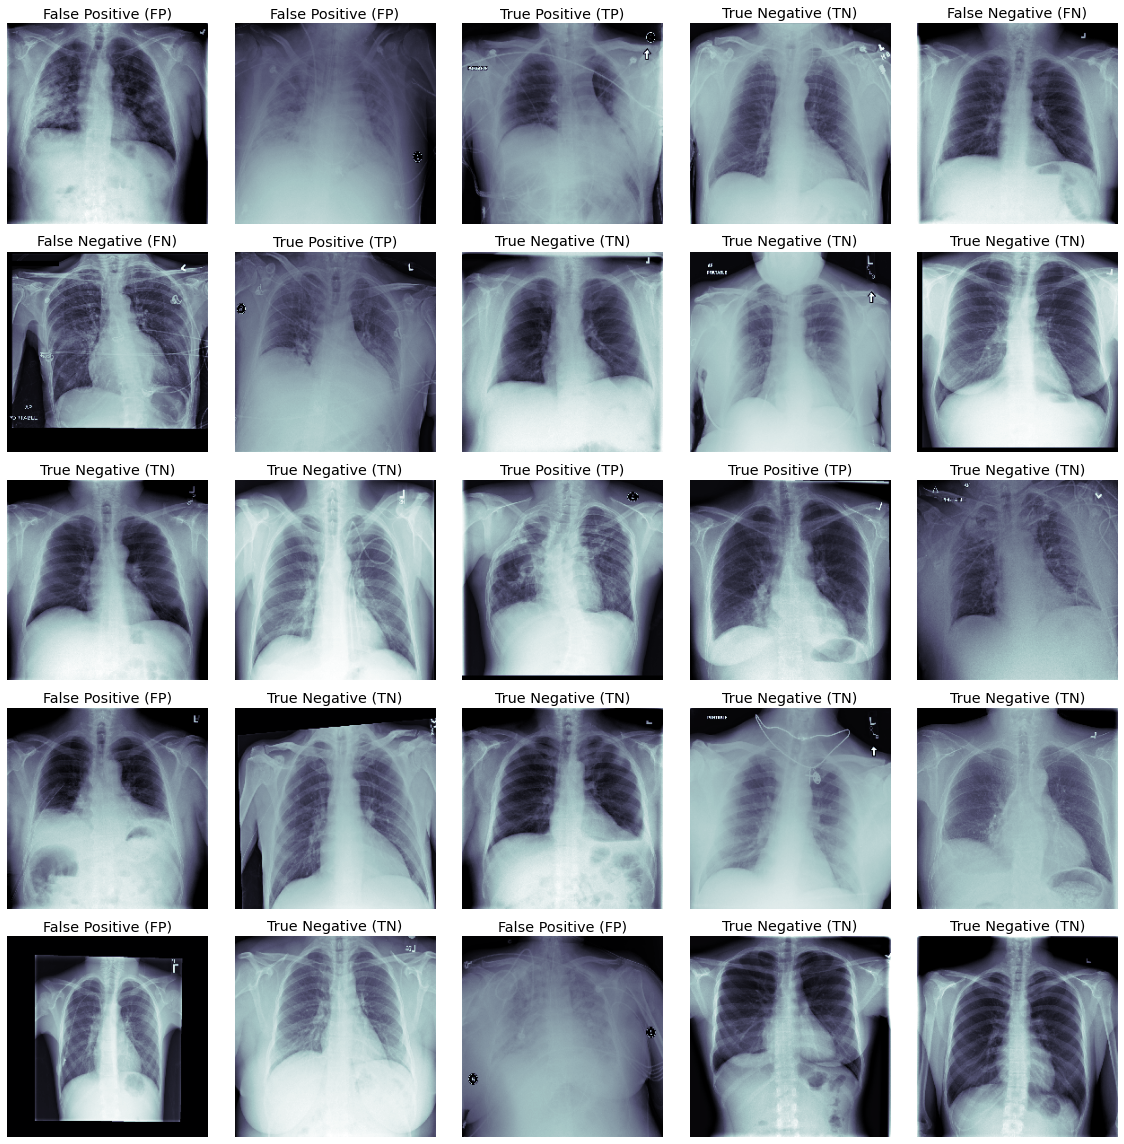

In [22]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0

# Mapping the conditions to descriptive labels
label_map = {
    '1, 1': 'True Positive (TP)',
    '1, 0': 'False Negative (FN)',
    '0, 1': 'False Positive (FP)',
    '0, 0': 'True Negative (TN)',
}

for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone')
    
    key = f"{int(c_y)}, {int(pred_Y[i] > best_thresh)}"
    c_ax.set_title(label_map.get(key, "Invalid"))
    
    c_ax.axis('off')
    i += 1

plt.tight_layout()
plt.show()


In [23]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)